In [3]:
import pandas as pd
import talib
import random
import matplotlib.pyplot as plt

In [4]:
data_df = pd.read_csv("data/XBTUSD-1d-data.csv")



In [738]:
# def convert_data_frame_5m_to_30m(data):
#     converted_data = []
#     if data.shape[0] > 6:
#         for i in range(0, data.shape[0] - 5, 6):
#             high = data[i:i + 5]['high'].max()
#             low = data[i:i + 5]['low'].min()
#             volume = data[i:i + 5]['volume'].sum()
#             converted_data.append({
#                 'timestamp': data.iloc[i]['timestamp'],
#                 'open': data.iloc[i]['open'],
#                 'high': high,
#                 'low': low,
#                 'close': data.iloc[i + 5]['close'],
#                 'volume': volume
#             })
#     else:
#         raise Exception('Too few 5m candles')
#     return pd.DataFrame(converted_data)


In [739]:
# data_df = convert_data_frame_5m_to_30m(data_df)
# data_df.to_csv("data/XBTUSD-30m-data.csv")


In [5]:
data_df

,timestamp,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
0,2017-06-02 00:00:00+00:00,XBTUSD,2304.1,2465.7,2302.0,2416.8,45572,57279425,2394.4067,60,2392274282144,23922.742821,5.727942e+07
1,2017-06-03 00:00:00+00:00,XBTUSD,2416.8,2501.2,2376.0,2497.9,29519,41297438,2434.5116,20,1696351952632,16963.519526,4.129744e+07
2,2017-06-04 00:00:00+00:00,XBTUSD,2497.9,2582.5,2450.0,2543.4,41882,54746338,2533.4414,234,2160991379308,21609.913793,5.474634e+07
3,2017-06-05 00:00:00+00:00,XBTUSD,2543.4,2569.4,2464.2,2529.3,31045,43808075,2518.7014,4,1739323597383,17393.235974,4.380808e+07
4,2017-06-06 00:00:00+00:00,XBTUSD,2529.3,2723.4,2523.3,2715.4,37262,52810719,2625.9815,100,2011113927665,20111.139277,5.281072e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,2020-11-21 00:00:00+00:00,XBTUSD,17824.0,18837.5,17763.0,18672.5,378892,2331879627,18362.1006,195,12701640868931,127016.408689,2.331880e+09
1269,2020-11-22 00:00:00+00:00,XBTUSD,18672.5,18989.5,18283.5,18725.0,344309,1851016742,18712.5749,10,9893621495189,98936.214952,1.851017e+09
1270,2020-11-23 00:00:00+00:00,XBTUSD,18725.0,18781.5,17656.0,18464.0,387726,2186105725,18341.8929,35,11920159190551,119201.591906,2.186106e+09
1271,2020-11-24 00:00:00+00:00,XBTUSD,18464.0,18785.0,18045.0,18393.5,373871,2156681517,18446.7810,11,11693390327421,116933.903274,2.156682e+09


In [615]:
# WINDOW = 100
# EMA_SUPER_SLOW = 200
# EMA_SLOW = 89
# EMA_FAST = 34

# ema_fast = talib.EMA(data_df['close'], timeperiod=EMA_FAST)
# ema_slow = talib.EMA(data_df['close'], timeperiod=EMA_SLOW)
# ema_super_slow = talib.EMA(data_df['close'], timeperiod=EMA_SUPER_SLOW)
# ema_fast_df = pd.DataFrame({"ema_fast": ema_fast})
# ema_slow_df = pd.DataFrame({"ema_slow": ema_fast})
# ema_super_slow_df = pd.DataFrame({"ema_super_slow": ema_super_slow})
# data_df = data_df.join(ema_fast_df["ema_fast"])
# data_df = data_df.join(ema_slow_df["ema_slow"])
# data_df = data_df.join(ema_super_slow_df["ema_super_slow"])



In [48]:
def find_best_ma(data):
    loss = 999999999
    EMA = 200
    for i in range(2, 200):
        ema = talib.EMA(data['close'], timeperiod=i)
        ema_df = pd.DataFrame({"ema": ema})
        joined_data = data.join(ema_df["ema"])
        high_d = joined_data[joined_data['low'] >= joined_data['ema']]
        low_d = joined_data[joined_data['high'] <= joined_data['ema']]
        medium_d = joined_data[(joined_data['low'] < joined_data['ema']) & (joined_data['high'] > joined_data['ema'])]
        temp_loss = abs((high_d['low'] - high_d['ema']).sum()) + abs((low_d['ema'] - low_d['high']).sum()) + (medium_d['high'] - medium_d['low']).sum()
        
#         temp_loss = abs((joined_data['low'] - joined_data['ema']).sum())
#         print(temp_loss)
        loss = min(loss,temp_loss)
        if loss == temp_loss:
            EMA = i
    print (EMA)
    return EMA

In [52]:
a = find_best_ma(data_df[600:900])

10


In [53]:
%%time
def optimized_ema(data):
    # params
    WINDOW = 200
    EMA = 200
    ema_series = []
    for index, row in data.iterrows():
        if index >= WINDOW and index < data.shape[0] - WINDOW:
#             print ("index: ",index)
            print (index-WINDOW, index+WINDOW)
            temp_data = data[index-WINDOW: index+ WINDOW]
#             temp_data = data[400: 800]
            best_ema = find_best_ma(temp_data)
            print( "BEST: ", best_ema)
            if EMA != best_ema:
                EMA = best_ema
            ema = talib.EMA(temp_data['close'], timeperiod=EMA)
            
            if len(ema_series) == 0:
                ema_series = ema
                print ("init: ", len(ema_series) )
            else:
                ema_series = ema_series.append(pd.Series(ema.iloc[-1], index=[ema_series.index.max()+1]))
                print ("len: ", len(ema_series))
    return ema_series

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 13.1 µs


In [33]:
# ema = talib.EMA(data_df['close'], timeperiod=39)
# ema_series = pd.Series(dtype='float64')
# ema_series.append(ema)

In [57]:
%%time
ema = optimized_ema(data_df)

0 400
9
BEST:  9
init:  400
1 401
11
BEST:  11
len:  401
2 402
11
BEST:  11
len:  402
3 403
11
BEST:  11
len:  403
4 404
13
BEST:  13
len:  404
5 405
11
BEST:  11
len:  405
6 406
11
BEST:  11
len:  406
7 407
12
BEST:  12
len:  407
8 408
11
BEST:  11
len:  408
9 409
11
BEST:  11
len:  409
10 410
11
BEST:  11
len:  410
11 411
9
BEST:  9
len:  411
12 412
9
BEST:  9
len:  412
13 413
12
BEST:  12
len:  413
14 414
11
BEST:  11
len:  414
15 415
9
BEST:  9
len:  415
16 416
9
BEST:  9
len:  416
17 417
9
BEST:  9
len:  417
18 418
9
BEST:  9
len:  418
19 419
9
BEST:  9
len:  419
20 420
9
BEST:  9
len:  420
21 421
9
BEST:  9
len:  421
22 422
9
BEST:  9
len:  422
23 423
9
BEST:  9
len:  423
24 424
9
BEST:  9
len:  424
25 425
9
BEST:  9
len:  425
26 426
9
BEST:  9
len:  426
27 427
9
BEST:  9
len:  427
28 428
9
BEST:  9
len:  428
29 429
9
BEST:  9
len:  429
30 430
9
BEST:  9
len:  430
31 431
9
BEST:  9
len:  431
32 432
9
BEST:  9
len:  432
33 433
9
BEST:  9
len:  433
34 434
9
BEST:  9
len:  434
35 43

9
BEST:  9
len:  677
278 678
9
BEST:  9
len:  678
279 679
9
BEST:  9
len:  679
280 680
9
BEST:  9
len:  680
281 681
9
BEST:  9
len:  681
282 682
9
BEST:  9
len:  682
283 683
9
BEST:  9
len:  683
284 684
9
BEST:  9
len:  684
285 685
9
BEST:  9
len:  685
286 686
9
BEST:  9
len:  686
287 687
9
BEST:  9
len:  687
288 688
9
BEST:  9
len:  688
289 689
9
BEST:  9
len:  689
290 690
9
BEST:  9
len:  690
291 691
7
BEST:  7
len:  691
292 692
7
BEST:  7
len:  692
293 693
7
BEST:  7
len:  693
294 694
7
BEST:  7
len:  694
295 695
9
BEST:  9
len:  695
296 696
9
BEST:  9
len:  696
297 697
9
BEST:  9
len:  697
298 698
9
BEST:  9
len:  698
299 699
9
BEST:  9
len:  699
300 700
9
BEST:  9
len:  700
301 701
9
BEST:  9
len:  701
302 702
9
BEST:  9
len:  702
303 703
9
BEST:  9
len:  703
304 704
9
BEST:  9
len:  704
305 705
9
BEST:  9
len:  705
306 706
9
BEST:  9
len:  706
307 707
9
BEST:  9
len:  707
308 708
9
BEST:  9
len:  708
309 709
9
BEST:  9
len:  709
310 710
9
BEST:  9
len:  710
311 711
9
BEST:  9
len

14
BEST:  14
len:  958
559 959
14
BEST:  14
len:  959
560 960
14
BEST:  14
len:  960
561 961
14
BEST:  14
len:  961
562 962
14
BEST:  14
len:  962
563 963
14
BEST:  14
len:  963
564 964
14
BEST:  14
len:  964
565 965
14
BEST:  14
len:  965
566 966
14
BEST:  14
len:  966
567 967
14
BEST:  14
len:  967
568 968
14
BEST:  14
len:  968
569 969
14
BEST:  14
len:  969
570 970
14
BEST:  14
len:  970
571 971
14
BEST:  14
len:  971
572 972
14
BEST:  14
len:  972
573 973
14
BEST:  14
len:  973
574 974
14
BEST:  14
len:  974
575 975
14
BEST:  14
len:  975
576 976
14
BEST:  14
len:  976
577 977
14
BEST:  14
len:  977
578 978
14
BEST:  14
len:  978
579 979
14
BEST:  14
len:  979
580 980
14
BEST:  14
len:  980
581 981
14
BEST:  14
len:  981
582 982
14
BEST:  14
len:  982
583 983
14
BEST:  14
len:  983
584 984
14
BEST:  14
len:  984
585 985
14
BEST:  14
len:  985
586 986
14
BEST:  14
len:  986
587 987
14
BEST:  14
len:  987
588 988
14
BEST:  14
len:  988
589 989
14
BEST:  14
len:  989
590 990
14
BEST:

10
BEST:  10
len:  1212
813 1213
10
BEST:  10
len:  1213
814 1214
10
BEST:  10
len:  1214
815 1215
10
BEST:  10
len:  1215
816 1216
10
BEST:  10
len:  1216
817 1217
10
BEST:  10
len:  1217
818 1218
10
BEST:  10
len:  1218
819 1219
10
BEST:  10
len:  1219
820 1220
10
BEST:  10
len:  1220
821 1221
10
BEST:  10
len:  1221
822 1222
10
BEST:  10
len:  1222
823 1223
10
BEST:  10
len:  1223
824 1224
10
BEST:  10
len:  1224
825 1225
10
BEST:  10
len:  1225
826 1226
10
BEST:  10
len:  1226
827 1227
10
BEST:  10
len:  1227
828 1228
10
BEST:  10
len:  1228
829 1229
10
BEST:  10
len:  1229
830 1230
10
BEST:  10
len:  1230
831 1231
10
BEST:  10
len:  1231
832 1232
10
BEST:  10
len:  1232
833 1233
10
BEST:  10
len:  1233
834 1234
10
BEST:  10
len:  1234
835 1235
10
BEST:  10
len:  1235
836 1236
10
BEST:  10
len:  1236
837 1237
10
BEST:  10
len:  1237
838 1238
10
BEST:  10
len:  1238
839 1239
10
BEST:  10
len:  1239
840 1240
10
BEST:  10
len:  1240
841 1241
10
BEST:  10
len:  1241
842 1242
10
BEST:  

In [58]:
ema

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
1267    16706.160967
1268    17063.677155
1269    17365.735854
1270    17565.420244
1271    17715.980200
Length: 1272, dtype: float64

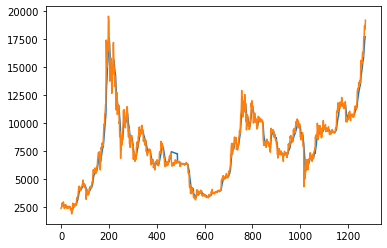

In [59]:
# EMA = run_strategy(data_df)
# print (EMA)
# ema = talib.EMA(data_df['close'], timeperiod=EMA)

plt.plot(ema)
# plt.plot(data_df[-365:-1]['high'])
plt.plot(data_df['close'])
# plt.plot(data_df[-365:-1]['low'])
plt.show()

In [60]:
def performance_report(data, order_df):
    total_profit = order_df['profit'].sum()
    max_dd = order_df['draw_down_percent'].min()
    max_ru = order_df['run_up_percent'].max()
    num_win = order_df[order_df.profit >= 0].count().profit
    num_loss = order_df[order_df.profit < 0].count().profit
    total_win_profit = order_df[order_df.profit >= 0].sum().profit
    total_loss_profit = order_df[order_df.profit < 0].sum().profit
    ave_win = total_win_profit / num_win
    ave_loss = total_loss_profit / num_loss
    win_rate = num_win / (num_win + num_loss)
    start_price = data.iloc[0]['close']
    end_price = data.iloc[-1]['close']
    market = (end_price / start_price - 1) * 100
    start_balance = 100
    balance = start_balance * (1 + total_profit / 100)
    relative_profit = balance - start_balance
    relative_yearly_profit = relative_profit / 3
    sharpe = 10
    trades = order_df.shape[0] * 2

    return {'profit': float(total_profit), 'max_dd': float(max_dd), 'max_ru': float(max_ru),
            'num_win': int(num_win), 'num_loss': int(num_loss),
            'total_win_profit': int(total_win_profit),
            'total_loss_profit': int(total_loss_profit),
            'ave_win': float(ave_win), 'ave_loss': float(ave_loss),
            'win_rate': float(win_rate), 'balance': float(balance), 'startBalance': float(start_balance),
            'relativeYearlyProfit': float(relative_yearly_profit), 'market': float(market), 'sharpe': float(sharpe),
            'trades': int(trades), 'startPrice': start_price, 'endPrice': end_price, 'relativeProfit': relative_profit}


In [74]:
def run_strategy(data, ema, params):
    entry_long = 0
    entry_short = 99999
    rr = 3
    stop_loss = params['stop_loss']
    take_profit = params['take_profit']
    in_long_position = False
    in_short_position = False
    dd_long = 0
    ru_long = 0
    dd_short = 0
    ru_short = 0
    order_history = []
    start_time_long = None
    start_time_short = None
    for index, row in data.iterrows():
        if index == 1272:
            break
        price = data.iloc[index]['close']
        low = data.iloc[index]['low']
        high = data.iloc[index]['high']
        timestamp = data.iloc[index]['timestamp']

        if not in_long_position and price >= 1.02 * ema[index]:
            #             print ("Long limit: ", ema_long[index] * 1.00 )
            entry_long = ema[index] * 1.00
        elif not in_short_position and price <= 0.98 * ema[index]:
            #             print ("Short limit: ", ema[index] * 1)
            entry_short = ema[index] * 1

        if in_long_position:
            dd_long = min(low, dd_long)
            ru_long = max(high, ru_long)
            dd_long_percent = (dd_long / entry_long - 1) * 100
            ru_long_percent = (ru_long / entry_long - 1) * 100
            profit = (price / entry_long - 1) * 100
            stop = (low / entry_long - 1) * 100
            if stop <= stop_loss or profit >= take_profit:
                if stop <= stop_loss:
                    exit_long = low
                else:
                    exit_long = price
                profit = (exit_long / entry_long - 1) * 100
                #                 print("Exit long: ", start_time, timestamp, entry_long)
                order_history.append(
                    {"from": start_time_long, "to": timestamp, "type": "long", "entry": entry_long, "exit": exit_long,
                     "profit": profit, "dd": dd_long, "ru": ru_long, "draw_down_percent": dd_long_percent,
                     "run_up_percent": ru_long_percent})
                entry_long = ru_long = dd_long = 0
                in_long_position = False
                start_time_long = None
        elif not in_long_position and entry_long >= low:
            #             print ("Filled, lowest price:", low)
            in_long_position = True
            dd_long = ru_long = entry_long
            start_time_long = timestamp

        if in_short_position:
            dd_short = max(high, dd_short)
            ru_short = min(low, ru_short)
            dd_short_percent = (1 - dd_short / entry_short) * 100
            ru_short_percent = (1 - ru_short / entry_short) * 100
            profit = (1 - price / entry_short) * 100
            stop = (1 - high / entry_short) * 100
            if stop <= stop_loss or profit >= take_profit:
                if stop <= stop_loss:
                    exit_short = high
                else:
                    exit_short = price
                profit = (1 - exit_short / entry_short) * 100
                #                 print("Exit short: ", start_time, timestamp, exit_short)
                order_history.append({"from": start_time_short, "to": timestamp, "type": "short", "entry": entry_short,
                                      "exit": exit_short, "profit": profit, "dd": dd_short, "ru": ru_short,
                                      "draw_down_percent": dd_short_percent, "run_up_percent": ru_short_percent})
                ru_short = dd_short = 0
                entry_short = 99999
                in_short_position = False
                start_time_short = None
        elif not in_short_position and entry_short <= high:
            #             print ("Filled, highest price:", high, entry_short)
            in_short_position = True
            dd_short = ru_short = entry_short
            start_time_short = timestamp
    return pd.DataFrame(order_history)


In [79]:
oh = run_strategy(data_df, ema, {"stop_loss": -3, "take_profit": 13} )
oh.to_csv("result/XBTUSD-1d-results.csv")
pr = performance_report(data_df, oh)


In [80]:
oh

,from,to,type,entry,exit,profit,dd,ru,draw_down_percent,run_up_percent
0,2017-06-13 00:00:00+00:00,2017-06-14 00:00:00+00:00,long,2766.263111,2635.1,-4.741527,2635.100000,2790.3,-4.741527,0.868930
1,2017-06-21 00:00:00+00:00,2017-06-25 00:00:00+00:00,long,2617.041261,2502.0,-4.395852,2502.000000,2788.9,-4.395852,6.566910
2,2017-07-06 00:00:00+00:00,2017-07-09 00:00:00+00:00,long,2548.554599,2467.4,-3.184338,2467.400000,2618.7,-3.184338,2.752360
3,2017-06-13 00:00:00+00:00,2017-07-11 00:00:00+00:00,short,2744.310489,2335.2,14.907588,2802.500000,2095.5,-2.120369,23.642022
4,2017-07-18 00:00:00+00:00,2017-07-19 00:00:00+00:00,short,2224.765192,2387.0,-7.292222,2387.000000,2150.0,-7.292222,3.360588
...,...,...,...,...,...,...,...,...,...,...
142,2020-09-21 00:00:00+00:00,2020-09-22 00:00:00+00:00,long,10791.374543,10280.0,-4.738734,10280.000000,10984.0,-4.738734,1.784995
143,2020-09-22 00:00:00+00:00,2020-10-10 00:00:00+00:00,short,10740.308578,11102.5,-3.372263,11102.500000,10130.0,-3.372263,5.682412
144,2020-10-17 00:00:00+00:00,2020-10-22 00:00:00+00:00,long,11243.038582,12814.0,13.972748,11221.500000,13239.0,-0.191573,17.752865
145,2020-11-03 00:00:00+00:00,2020-11-06 00:00:00+00:00,long,13304.107682,15605.0,17.294601,13288.000000,15791.5,-0.121073,18.696424


In [81]:
pr

{'profit': 495.50635492525294,
 'max_dd': -22.79265392664742,
 'max_ru': 52.85959281101027,
 'num_win': 58,
 'num_loss': 89,
 'total_win_profit': 1033,
 'total_loss_profit': -538,
 'ave_win': 17.826700558891204,
 'ave_loss': -6.04991323022963,
 'win_rate': 0.3945578231292517,
 'balance': 595.5063549252529,
 'startBalance': 100.0,
 'relativeYearlyProfit': 165.16878497508432,
 'market': 694.1492883151274,
 'sharpe': 10.0,
 'trades': 294,
 'startPrice': 2416.8,
 'endPrice': 19193.0,
 'relativeProfit': 495.50635492525294}

In [78]:
profit = 0
best_params = {}
best_pr = {}
for st in range(-20,-1):
    for tp in range(2,60):
        params = {"stop_loss": st, "take_profit": tp}
        order_history_df = run_strategy(data_df, ema, params )
        pr = performance_report(data_df, order_history_df)
        profit = max(profit, pr['profit'])
        if (profit == pr['profit']):
            best_params = params
            best_pr = pr

print ("-------------------------")
print (best_params)
print (best_pr)


-------------------------
{'stop_loss': -3, 'take_profit': 13}
{'profit': 495.50635492525294, 'max_dd': -22.79265392664742, 'max_ru': 52.85959281101027, 'num_win': 58, 'num_loss': 89, 'total_win_profit': 1033, 'total_loss_profit': -538, 'ave_win': 17.826700558891204, 'ave_loss': -6.04991323022963, 'win_rate': 0.3945578231292517, 'balance': 595.5063549252529, 'startBalance': 100.0, 'relativeYearlyProfit': 165.16878497508432, 'market': 694.1492883151274, 'sharpe': 10.0, 'trades': 294, 'startPrice': 2416.8, 'endPrice': 19193.0, 'relativeProfit': 495.50635492525294}


In [ ]:
order_history_df = pd.DataFrame(order_history)

In [424]:
order_history_df

,type,entry,exit,profit,dd,ru,draw_down_percent,run_up_percent
0,short,2689.846093,2817.7,-4.753205,2817.7,0.0,-4.753205,100.0
1,short,2729.319251,2432.9,10.860556,2432.9,0.0,10.860556,100.0
2,short,2425.576565,2626.3,-8.275288,2626.3,0.0,-8.275288,100.0
3,short,2515.328836,2598.8,-3.318499,2598.8,0.0,-3.318499,100.0
4,short,2636.616994,2699.9,-2.400159,2699.9,0.0,-2.400159,100.0
...,...,...,...,...,...,...,...,...
65,short,6852.839072,6296.5,8.118374,6296.5,0.0,8.118374,100.0
66,short,6386.062952,6706.5,-5.017756,6706.5,0.0,-5.017756,100.0
67,short,6650.391636,6048.5,9.050469,6048.5,0.0,9.050469,100.0
68,short,6138.502404,6383.5,-3.991162,6383.5,0.0,-3.991162,100.0


In [426]:
order_history_df.to_csv("result/XBTUSD-1d-results.csv")


In [427]:
performance_report(order_history_df)


{'profit': 83.02581948846826,
 'max_dd': -15.969677123540226,
 'max_ru': 100.0,
 'num_win': 30,
 'num_loss': 40,
 'total_win_profit': 316,
 'total_loss_profit': -233,
 'ave_win': 10.555755941706613,
 'ave_loss': -5.841171469068254,
 'win_rate': 0.42857142857142855,
 'balance': 183.02581948846824,
 'startBalance': 100.0,
 'relativeYearlyProfit': 27.675273162822748,
 'market': 144.69801518108335,
 'sharpe': 10.0,
 'trades': 140,
 'startPrice': 2689.846092592593,
 'endPrice': 6582.0,
 'relativeProfit': 83.02581948846824}